# **Modeling**

In this section of the data science method we finally use our data to develop a model to predict the temperature of the target room in the house. 

We will use a SARIMAX model, which does everything an ARIMA model can do, which does everything an AR or an MA model can do based on the parameters you pass it. SARIMAX goes beyond ARIMA by accounting for highly seasonal data, which ours is. Both models can handle exogenous data. For comparison we will also use a random forest regressor. 

### Section 1: Imports and Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [72]:
train = pd.read_csv('../Data/train_scaled_df.csv', parse_dates = ['Unnamed: 0'], index_col = 'Unnamed: 0')
train.index = pd.date_range(start = train.index[0], end = train.index[-1], freq='15min')

test = pd.read_csv('../Data/test_scaled_df.csv', parse_dates = ['Unnamed: 0'], index_col = 'Unnamed: 0')
test.index = pd.date_range(start = test.index[0], end = test.index[-1], freq='15min')

In [3]:
train.head()

,co2_dining_room,co2_room,relative_humidity_dining_room,relative_humidity_room,lighting_dining_room,lighting_room,wind,sun_light_in_west_facade,sun_light_in_east_facade,sun_light_in_south_facade,sun_irradiance,outdoor_relative_humidity,rain_none,rain_rain,sun_dusk_full,sun_dusk_none,sun_dusk_partial,indoor_temperature_room
2012-03-13 11:45:00,1.259658,1.715107,-0.674522,-0.591184,2.293957,1.696829,0.361028,-0.188425,0.005900,2.125555,1.871279,-0.635709,0.235308,-0.235308,0.988756,-0.931342,-0.175412,17.8275
2012-03-13 12:00:00,1.822433,1.462093,-0.672419,-0.612898,2.297159,1.698815,0.510874,-0.136147,-0.076794,2.125555,1.882173,-0.679815,0.235308,-0.235308,0.988756,-0.931342,-0.175412,18.1207
2012-03-13 12:15:00,1.732044,1.229717,-0.695332,-0.615278,2.283843,1.698698,0.781484,-0.020797,-0.127657,2.124431,1.896460,-0.709064,0.235308,-0.235308,0.988756,-0.931342,-0.175412,18.4367
2012-03-13 12:30:00,1.600779,0.922915,-0.694740,-0.631657,2.287087,1.692718,0.724231,0.157841,-0.128635,2.123304,1.895729,-0.740802,0.235308,-0.235308,0.988756,-0.931342,-0.175412,18.7513
2012-03-13 12:45:00,1.451404,0.766102,-0.694784,-0.635509,2.285593,1.685475,1.205828,0.465513,-0.148652,2.123145,1.884476,-0.861350,0.235308,-0.235308,0.988756,-0.931342,-0.175412,19.0414


In [4]:
test.head()

,co2_dining_room,co2_room,relative_humidity_dining_room,relative_humidity_room,lighting_dining_room,lighting_room,wind,sun_light_in_west_facade,sun_light_in_east_facade,sun_light_in_south_facade,sun_irradiance,outdoor_relative_humidity,rain_none,rain_rain,sun_dusk_full,sun_dusk_none,sun_dusk_partial,indoor_temperature_room
2012-04-05 12:30:00,-1.220738,-1.767126,1.679070,1.397576,1.869218,2.051067,2.068257,0.559222,0.488807,1.387201,2.094765,0.581603,0.235308,-0.235308,0.988756,-0.931342,-0.175412,21.1560
2012-04-05 12:45:00,-1.327078,-1.775901,1.675900,1.326943,2.332524,2.334635,2.222543,1.030489,0.438598,1.766622,2.607617,0.577456,0.235308,-0.235308,0.988756,-0.931342,-0.175412,21.3400
2012-04-05 13:00:00,-1.321761,-1.848702,1.697229,1.507108,0.944063,1.419546,1.904317,0.685870,0.309941,0.711389,1.426092,0.435150,0.235308,-0.235308,0.988756,-0.931342,-0.175412,21.5040
2012-04-05 13:15:00,-1.410323,-1.916302,1.740286,1.558982,-0.050365,0.393168,1.888044,0.263852,0.243795,0.082534,0.611519,0.426026,0.235308,-0.235308,0.988756,-0.931342,-0.175412,21.5693
2012-04-05 13:30:00,-1.449370,-2.028915,1.789268,1.523487,0.173063,0.955724,1.732547,0.308552,0.318111,0.041121,0.666906,0.468343,0.235308,-0.235308,0.988756,-0.931342,-0.175412,21.5840


In [73]:
# Split the training and testing sets into independent and dependent variables
X_train, y_train = train.drop(columns = 'indoor_temperature_room'), train['indoor_temperature_room']
X_test, y_test = test.drop(columns = 'indoor_temperature_room'), test['indoor_temperature_room']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2211, 17), (2211,), (553, 17), (553,))

### Section 2: SARIMAX Modeling

### 2.1 Manual Parameters

Based on the acf and pacf functions viewed in previous in the EDA section, we anticipate the best model is of order (p = 0, d = 1, q = 0) and seasonal order (P = 0, D = 1, Q = 1, S = ~100). Let's test these parameters first, and then see if we can use autoarima to hone in on more optimal parameters.

In [78]:
# Obtain the "cycle", i.e. the number of data points contained in one season (day) of our data
cycle = len(y_train.loc['2012-03-21 00:00:000': '2012-03-22 00:00:000']) - 1
cycle

96

In [8]:
# Train the model
model = SARIMAX(y_train, exog = X_train, order = (0, 1, 0), seasonal_order = (0, 1, 1, cycle), trend = 'c')

In [9]:
# Fit the model
sarimax1_results = model.fit()

In [10]:
sarimax1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:              indoor_temperature_room   No. Observations:                 2211
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 96)   Log Likelihood                2438.455
Date:                              Sat, 16 Jul 2022   AIC                          -4836.909
Time:                                      17:07:11   BIC                          -4723.783
Sample:                                  03-13-2012   HQIC                         -4795.488
                                       - 04-05-2012                                         
Covariance Type:                                opg                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
intercept                       1.76e-05      0.000      0.041      0.968      -0.001       0.001
co2_dining_room                   0.0296      0.009      3.405      0.001       0.013       0.047
co2_room                          0.0455      0.005      8.356      0.000       0.035       0.056
relative_humidity_dining_room     0.0660      0.021      3.168      0.002       0.025       0.107
relative_humidity_room           -0.3520      0.024    -14.863      0.000      -0.398      -0.306
lighting_dining_room              0.0138      0.010      1.424      0.154      -0.005       0.033
lighting_room                     0.0033      0.012      0.289      0.773      -0.019       0.026
wind                              0.0062      0.004      1.411      0.158      -0.002       0.015
sun_light_in_west_facade          0.0459      0.013      3.583      0.000       0.021       0.071
sun_light_in_east_facade         -0.0712      0.011     -6.407      0.000      -0.093      -0.049
sun_light_in_south_facade         0.0770      0.031      2.478      0.013       0.016       0.138
sun_irradiance                   -0.0785      0.028     -2.756      0.006      -0.134      -0.023
outdoor_relative_humidity        -0.1332      0.024     -5.617      0.000      -0.180      -0.087
rain_none                        -0.0020      0.003     -0.781      0.435      -0.007       0.003
rain_rain                        -0.0033      0.003     -1.244      0.213      -0.008       0.002
sun_dusk_full                    -0.0079      0.012     -0.653      0.514      -0.032       0.016
sun_dusk_none                     0.0024      0.013      0.189      0.850      -0.022       0.027
sun_dusk_partial              -5.859e-05      0.003     -0.017      0.987      -0.007       0.007
ma.S.L96                         -0.8647      0.022    -39.776      0.000      -0.907      -0.822
sigma2                            0.0055      0.000     45.308      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                 995.43   Jarque-Bera (JB):             25111.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.07e+17. Standard errors may be unstable.
"""

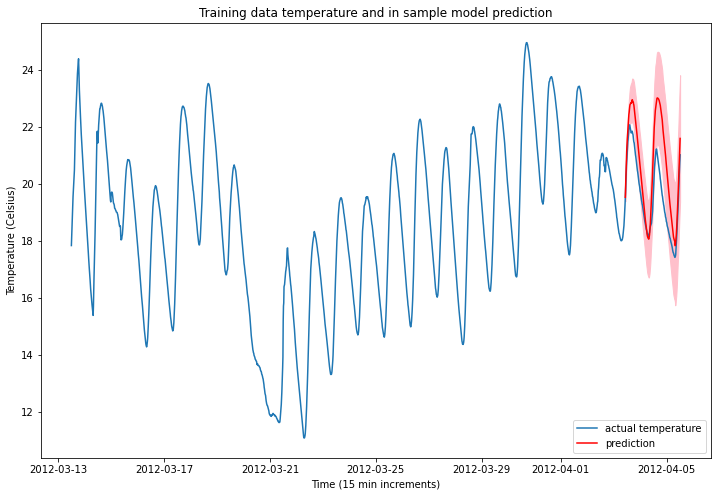

In [11]:
# View the model's prediction of the last 200 periods of the training set
prediction = sarimax1_results.get_prediction(start = -200, dynamic = True)
mean_prediction = prediction.predicted_mean
confidence_intervals = prediction.conf_int()

plt.figure(figsize = (12, 8))
plt.plot(y_train, label = 'actual temperature')
plt.plot(mean_prediction, color = 'red', label = 'prediction')
plt.fill_between(mean_prediction.index, confidence_intervals['lower indoor_temperature_room'], 
                 confidence_intervals['upper indoor_temperature_room'],
                color = 'pink')
plt.legend(loc = 4)
plt.title('Training data temperature and in sample model prediction')
plt.xlabel('Time (15 min increments)')
plt.ylabel('Temperature (Celsius)')
plt.show()

In [80]:
# Forecast test set values
forecast = sarimax1_results.predict(start = len(train), end=(len(train) + len(test) - 1),exog=X_test)

In [81]:
forecast

2012-04-05 12:30:00    21.270164
2012-04-05 12:45:00    21.514919
2012-04-05 13:00:00    21.617058
2012-04-05 13:15:00    21.721515
2012-04-05 13:30:00    21.839776
                         ...    
2012-04-11 05:30:00    20.322644
2012-04-11 05:45:00    20.218283
2012-04-11 06:00:00    20.122527
2012-04-11 06:15:00    20.004416
2012-04-11 06:30:00    19.915479
Freq: 15T, Name: predicted_mean, Length: 553, dtype: float64

In [82]:
forecast.shape, y_test.shape

((553,), (553,))

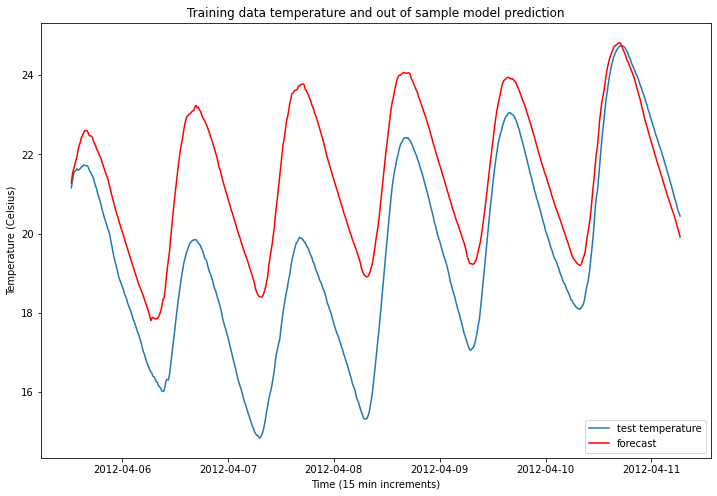

In [83]:
# View the out of sample forecast
plt.figure(figsize = (12, 8))
plt.plot(y_test, label = 'test temperature')
plt.plot(forecast, color = 'red', label = 'forecast')

plt.legend(loc = 4)
plt.title('Training data temperature and out of sample model prediction')
plt.xlabel('Time (15 min increments)')
plt.ylabel('Temperature (Celsius)')
plt.show()

In [84]:
y_test.shape, forecast.shape

((553,), (553,))

In [85]:
# Calculate out of sample error metrics
rmse_manual_SARIMAX = mean_squared_error(y_test,forecast, squared = False)
r2_manual_SARIMAX = r2_score(y_test, forecast)

# Store error metrics for later
rmses = []
r2s = []
rmses.append(rmse_manual_SARIMAX)
r2s.append(r2_manual_SARIMAX)

rmse_manual_SARIMAX, r2_manual_SARIMAX

(2.4077544293008377, 0.03755651481617106)

This model takes far too long to fit. We suspect the high seasonality cycle of 96 causes fitting time to take so long, on the order of about 30 minutes. If we're going to fine tune, we need a model that fits faster. We don't lose too much information by downsampling to an hourly period. We try this in the next section.

### 2.2 Hourly Downsampled SARIMAX with Manual Parameters

In [17]:
# Downsample the training and test sets into hourly periods
hourly_train = train.resample('H').last()
hourly_test = test.resample('H').last()

In [18]:
# Seperate our down sampled variable sets into x's and y's
X_train_hourly, y_train_hourly = hourly_train.drop(columns = 'indoor_temperature_room'), hourly_train['indoor_temperature_room']
X_test_hourly, y_test_hourly = hourly_test.drop(columns = 'indoor_temperature_room'), hourly_test['indoor_temperature_room']

In [19]:
# Since we've resampled our data to hourly, the new cycle will be 24 for each hour in the day
hourly_cycle = 24

In [20]:
# Instantiate the SARIMAX model again with our manually obtained parameters and the downsampled cycle
model = SARIMAX(y_train_hourly, exog = X_train_hourly, order = (0, 1, 0), seasonal_order = (0, 1, 1, hourly_cycle), trend = 'c')

In [21]:
sarimax2_results = model.fit()

In [22]:
sarimax2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:              indoor_temperature_room   No. Observations:                  554
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 24)   Log Likelihood                 -24.059
Date:                              Sat, 16 Jul 2022   AIC                             88.119
Time:                                      17:09:21   BIC                            173.538
Sample:                                  03-13-2012   HQIC                           121.556
                                       - 04-05-2012                                         
Covariance Type:                                opg                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
intercept                         0.0004      0.002      0.156      0.876      -0.004       0.005
co2_dining_room                   0.0822      0.034      2.422      0.015       0.016       0.149
co2_room                          0.0592      0.026      2.270      0.023       0.008       0.110
relative_humidity_dining_room     0.1681      0.073      2.300      0.021       0.025       0.311
relative_humidity_room           -0.7030      0.095     -7.431      0.000      -0.888      -0.518
lighting_dining_room             -0.0041      0.045     -0.091      0.928      -0.093       0.085
lighting_room                    -0.1114      0.055     -2.024      0.043      -0.219      -0.004
wind                              0.0076      0.020      0.377      0.706      -0.032       0.047
sun_light_in_west_facade          0.0733      0.037      1.974      0.048       0.001       0.146
sun_light_in_east_facade         -0.2502      0.034     -7.335      0.000      -0.317      -0.183
sun_light_in_south_facade         0.2201      0.109      2.022      0.043       0.007       0.434
sun_irradiance                   -0.0051      0.106     -0.049      0.961      -0.212       0.202
outdoor_relative_humidity        -0.1025      0.075     -1.375      0.169      -0.249       0.044
rain_none                         0.0023      0.009      0.259      0.795      -0.015       0.019
rain_rain                        -0.0047      0.009     -0.540      0.589      -0.022       0.012
sun_dusk_full                     0.0130      0.097      0.135      0.893      -0.177       0.203
sun_dusk_none                    -0.0118      0.093     -0.128      0.898      -0.193       0.170
sun_dusk_partial                 -0.0080      0.030     -0.266      0.790      -0.067       0.051
ma.S.L24                         -0.9187      0.055    -16.840      0.000      -1.026      -0.812
sigma2                            0.0592      0.003     18.070      0.000       0.053       0.066
===================================================================================
Ljung-Box (L1) (Q):                 159.49   Jarque-Bera (JB):               993.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.01e+17. Standard errors may be unstable.
"""

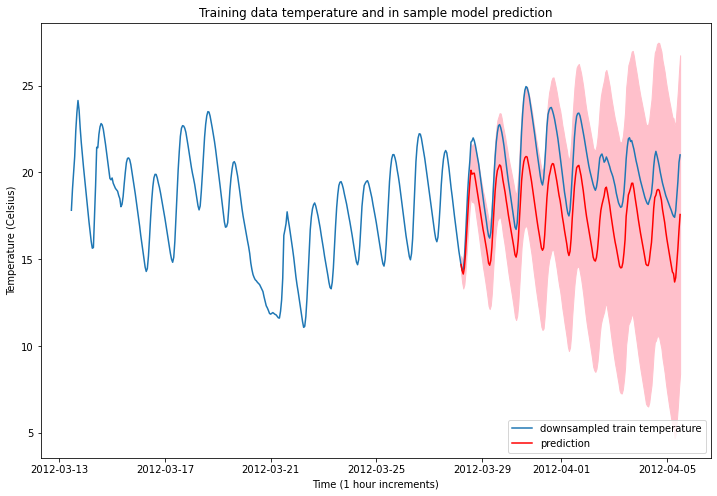

In [23]:
# View the model's prediction of the last 200 periods of the training set
prediction = sarimax2_results.get_prediction(start = -200, dynamic = True)
mean_forecast = prediction.predicted_mean
confidence_intervals = prediction.conf_int()

plt.figure(figsize = (12, 8))
plt.plot(y_train_hourly, label = 'downsampled train temperature')
plt.plot(mean_forecast, color = 'red', label = 'prediction')
plt.fill_between(mean_forecast.index, confidence_intervals['lower indoor_temperature_room'], 
                 confidence_intervals['upper indoor_temperature_room'],
                color = 'pink')
plt.legend(loc = 4)
plt.title('Training data temperature and in sample model prediction')
plt.xlabel('Time (1 hour increments)')
plt.ylabel('Temperature (Celsius)')
plt.show()

In [86]:
# And now forecast the test set values
forecast = sarimax2_results.predict(start = len(hourly_train), 
                                    end=(len(hourly_train) + len(hourly_test) - 1), 
                                    exog=X_test_hourly)

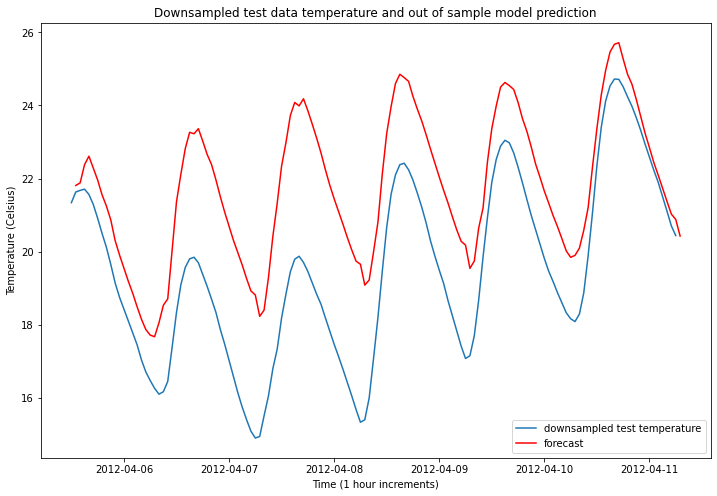

In [25]:
# View the out of sample forecast
plt.figure(figsize = (12, 8))
plt.plot(y_test_hourly, label = 'downsampled test temperature')
plt.plot(forecast, color = 'red', label = 'forecast')

plt.legend(loc = 4)
plt.title('Downsampled test data temperature and out of sample model prediction')
plt.xlabel('Time (1 hour increments)')
plt.ylabel('Temperature (Celsius)')
plt.show()

In [87]:
# And out of sample error metrics
rmse_downsampled_SARIMAX2 = mean_squared_error(y_test_hourly, forecast, squared = False)
r2_downsampled_SARIMAX2 = r2_score(y_test_hourly, forecast)

rmses.append(rmse_downsampled_SARIMAX2)
r2s.append(r2_downsampled_SARIMAX2)

rmse_downsampled_SARIMAX2, r2_downsampled_SARIMAX2

(2.647076147672971, -0.16755150376855665)

### 2.3 SARIMAX with Optimized Parameters

We've made forecasts with SARIMAX parameters we inferred from our work in the EDA section: from acf and pacf plots. We'd like now to apply auto_arima to see if its optimal SARIMAX parameters result in an imporoved model. pm.auto_arima is a lot like gridsearchCV, only for ARIMA models. From the documentation:

"Automatically discover the optimal order for an ARIMA model.

The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model. This process is based on the commonly-used R function, forecast::auto.arima [3].

Auto-ARIMA works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In order to find the best model, auto-ARIMA optimizes for a given information_criterion, one of (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’) (Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag”–for validation scoring–respectively) and returns the ARIMA which minimizes the value."

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

Letting auto_arima brute force its default parameters takes far too long and eventuated in consistent crashing due to memory errors. We suspect the original seasonality cycle of 97 causes fitting time to take way too long and is largely responsible for the crashing. Therefore, we'll run auto_arima on the downsampled hourly data. We'll also give it some starting parameters to further reduce operation time: the data is seasonal, we'll limit the p, P, q, and Q parameters to 3 max, and we know the data should be differenced so we'll give it d = 1 and D = 1.

In [27]:
# Attempt the auto_arima hyperparameter grid search with downsampled data
auto_arima_results = pm.auto_arima(y_train_hourly, X = X_train_hourly, m = hourly_cycle, error_action = 'ignore', 
                                   seasonal = True, max_p = 3, d = 1, max_q = 3, max_P = 3, D = 1, maxQ = 3)

In [28]:
auto_arima_results.fit(y_train_hourly)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(3, 1, 0, 24),
      suppress_warnings=True, with_intercept=False)

In [29]:
auto_arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  554
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 24)   Log Likelihood                  59.915
Date:                            Sat, 16 Jul 2022   AIC                           -109.829
Time:                                    17:34:46   BIC                            -88.474
Sample:                                         0   HQIC                          -101.470
                                            - 554                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6596      0.014     47.225      0.000       0.632       0.687
ar.S.L24      -0.7308      0.024    -30.203      0.000      -0.778      -0.683
ar.S.L48      -0.4761      0.030    -15.681      0.000      -0.536      -0.417
ar.S.L72      -0.2810      0.027    -10.516      0.000      -0.333      -0.229
sigma2         0.0451      0.001     38.101      0.000       0.043       0.047
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):              7905.33
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It looks like auto_arima deterimed the best parameters for the SARIMAX model is (1, 1, 0) (3, 1, 0, 24). It is possible to use the auto_arima results object to do our analysis, but we're more comfortable with the statsmodels API so we'll generate a new SARIMAX model using the recommended parameters.

In [30]:
# Instantiate the SARIMAX model again with the lighter cycle and recommended parameters
model = SARIMAX(y_train_hourly, exog = X_train_hourly, order = (1, 1, 0), seasonal_order = (3, 1, 0, hourly_cycle), trend = 'c')

In [31]:
sarimax3_results = model.fit()

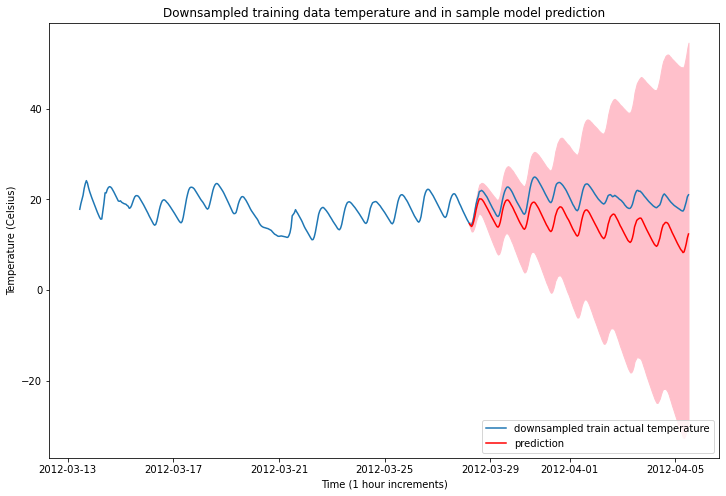

In [32]:
# View the model's forecast of the last 200 periods of the training set
prediction = sarimax3_results.get_prediction(start = -200, dynamic = True)
mean_forecast = prediction.predicted_mean
confidence_intervals = prediction.conf_int()

plt.figure(figsize = (12, 8))
plt.plot(y_train_hourly, label = 'downsampled train actual temperature')
plt.plot(mean_forecast, color = 'red', label = 'prediction')
plt.fill_between(mean_forecast.index, confidence_intervals['lower indoor_temperature_room'], 
                 confidence_intervals['upper indoor_temperature_room'],
                color = 'pink')
plt.legend(loc = 4)
plt.title('Downsampled training data temperature and in sample model prediction')
plt.xlabel('Time (1 hour increments)')
plt.ylabel('Temperature (Celsius)')
plt.show()

In [88]:
# And now forecast the test set values
forecast = sarimax3_results.predict(start = len(hourly_train), 
                                    end=(len(hourly_train) + len(hourly_test) - 1), 
                                    exog=X_test_hourly)

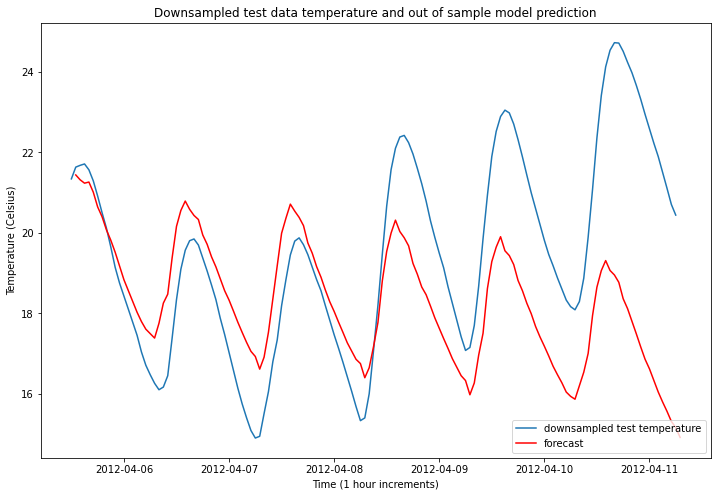

In [34]:
# View the out of sample forecast
plt.figure(figsize = (12, 8))
plt.plot(y_test_hourly, label = 'downsampled test temperature')
plt.plot(forecast, color = 'red', label = 'forecast')

plt.legend(loc = 4)
plt.title('Downsampled test data temperature and out of sample model prediction')
plt.xlabel('Time (1 hour increments)')
plt.ylabel('Temperature (Celsius)')
plt.show()

In [89]:
# And out of sample error metrics
rmse_tuned_SARIMAX3 = mean_squared_error(y_test_hourly, forecast, squared = False)
r2__tuned_SARIMAX3 = r2_score(y_test_hourly, forecast)

rmses.append(rmse_tuned_SARIMAX3)
r2s.append(r2__tuned_SARIMAX3)

rmse_tuned_SARIMAX3, r2__tuned_SARIMAX3

(2.7564554406534345, -0.26603330530035585)

### Section 3: Random Forest Regression

### 3.1 Untuned Random Forest Regressor

In [36]:
# Add feature of lagged temperature to introduce a temporal element
train['lagged_temp'] = train['indoor_temperature_room'].shift(periods = 1, 
                                                              fill_value = train['indoor_temperature_room'].mean())
test['lagged_temp'] = test['indoor_temperature_room'].shift(periods = 1, 
                                                              fill_value = test['indoor_temperature_room'].mean())

In [37]:
train.head()

,co2_dining_room,co2_room,relative_humidity_dining_room,relative_humidity_room,lighting_dining_room,lighting_room,wind,sun_light_in_west_facade,sun_light_in_east_facade,sun_light_in_south_facade,sun_irradiance,outdoor_relative_humidity,rain_none,rain_rain,sun_dusk_full,sun_dusk_none,sun_dusk_partial,indoor_temperature_room,lagged_temp
2012-03-13 11:45:00,1.259658,1.715107,-0.674522,-0.591184,2.293957,1.696829,0.361028,-0.188425,0.005900,2.125555,1.871279,-0.635709,0.235308,-0.235308,0.988756,-0.931342,-0.175412,17.8275,18.660664
2012-03-13 12:00:00,1.822433,1.462093,-0.672419,-0.612898,2.297159,1.698815,0.510874,-0.136147,-0.076794,2.125555,1.882173,-0.679815,0.235308,-0.235308,0.988756,-0.931342,-0.175412,18.1207,17.827500
2012-03-13 12:15:00,1.732044,1.229717,-0.695332,-0.615278,2.283843,1.698698,0.781484,-0.020797,-0.127657,2.124431,1.896460,-0.709064,0.235308,-0.235308,0.988756,-0.931342,-0.175412,18.4367,18.120700
2012-03-13 12:30:00,1.600779,0.922915,-0.694740,-0.631657,2.287087,1.692718,0.724231,0.157841,-0.128635,2.123304,1.895729,-0.740802,0.235308,-0.235308,0.988756,-0.931342,-0.175412,18.7513,18.436700
2012-03-13 12:45:00,1.451404,0.766102,-0.694784,-0.635509,2.285593,1.685475,1.205828,0.465513,-0.148652,2.123145,1.884476,-0.861350,0.235308,-0.235308,0.988756,-0.931342,-0.175412,19.0414,18.751300


In [38]:
# Split the training and testing sets into independent and dependent variables with the new feature
X_train, y_train = train.drop(columns = 'indoor_temperature_room'), train['indoor_temperature_room']
X_test, y_test = test.drop(columns = 'indoor_temperature_room'), test['indoor_temperature_room']

In [39]:
# Try untuned random forest regressor
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

RandomForestRegressor()

In [40]:
# Get forecast
forecast1 = rf.predict(X_test)

In [41]:
# Index forecast by time
forecast_by_time = pd.Series(forecast1, index = y_test.index)

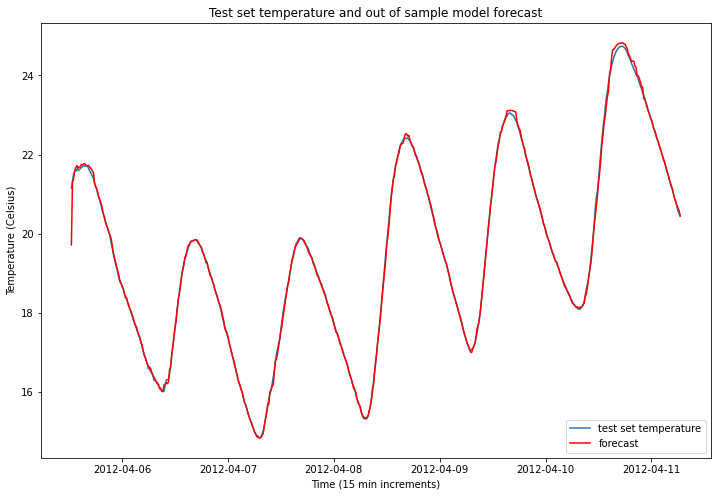

In [42]:
# Plot out of sample forecast
plt.figure(figsize = (12, 8))
plt.plot(y_test, label = 'test set temperature')
plt.plot(forecast_by_time, color = 'red', label = 'forecast')

plt.legend(loc = 4)
plt.title('Test set temperature and out of sample model forecast')
plt.xlabel('Time (15 min increments)')
plt.ylabel('Temperature (Celsius)')
plt.show()

In [90]:
# Calculate out of sample error
rmse_rf_untuned = mean_squared_error(y_test,forecast_by_time, squared = False)
r2_rf_untuned = r2_score(y_test, forecast_by_time)

rmses.append(rmse_rf_untuned)
r2s.append(r2_rf_untuned)

rmse_rf_untuned, r2_rf_untuned

(0.08619384433419171, 0.9987666016632935)

### 3.2 Tuned Random Forest Regressor

In [44]:
# Create hyperparameter grid
n_estimators = [50, 75, 100, 200, 400, 800, 1000]
max_features = ['auto', 'sqrt']
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [45]:
# Random search of parameters, using 3 fold cross validation
rf2 = RandomForestRegressor()
rf2_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, 
                                 cv = 3, n_jobs = -1)
# Fit the random search model
rf2_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 75, 100, 200, 400,
                                                         800, 1000]})

In [46]:
# Display best parameters
rf2_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

In [47]:
# Extract the best parameters from the random search
best_random = rf2_random.best_estimator_

In [48]:
# Get in sample predictions and index by time
in_sample_predictions2 = best_random.predict(X_train)
in_sample_predictions2_by_time = pd.Series(in_sample_predictions2, index = y_train.index)

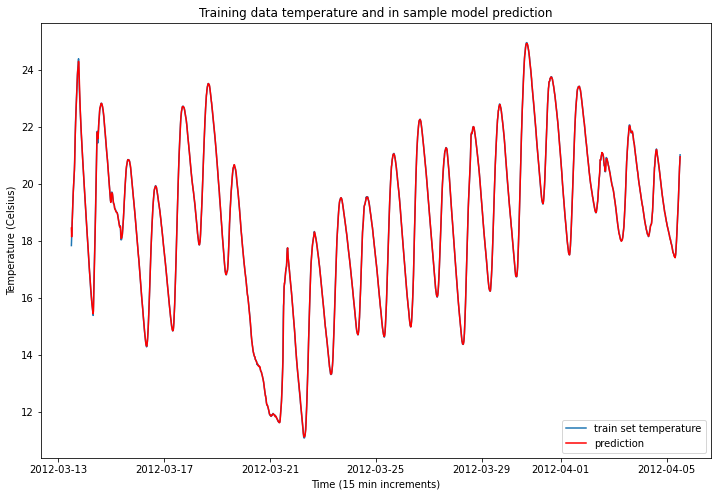

In [49]:
# Plot the in sample predictions
plt.figure(figsize = (12, 8))
plt.plot(y_train, label = 'train set temperature')
plt.plot(in_sample_predictions2_by_time, color = 'red', label = 'prediction')

plt.legend(loc = 4)
plt.title('Training data temperature and in sample model prediction')
plt.xlabel('Time (15 min increments)')
plt.ylabel('Temperature (Celsius)')
plt.show()

In [50]:
# Calculate in sample error
in_sample_rmse_tuned_rf = mean_squared_error(y_train, in_sample_predictions2_by_time, squared = False)
in_sample_r2_tuned_rf = r2_score(y_train, in_sample_predictions2_by_time)
print('The in sample rmse is', in_sample_rmse_tuned_rf, 'and the in sample r2 is', in_sample_r2_tuned_rf)

The in sample rmse is 0.038706790447201975 and the in sample r2 is 0.9998195966388089


In [51]:
# Now get out of sample forecast and index by time
forecast2 = best_random.predict(X_test)
forecast2_by_time = pd.Series(forecast2, index = y_test.index)

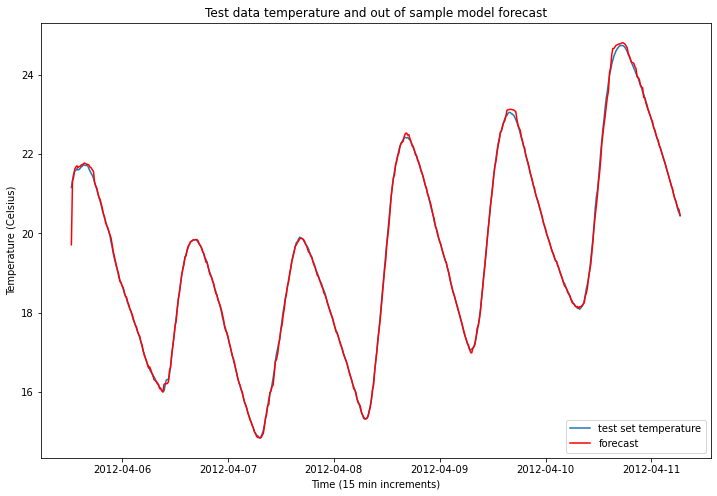

In [52]:
# Plot out of sample predictions
plt.figure(figsize = (12, 8))
plt.plot(y_test, label = 'test set temperature')
plt.plot(forecast2_by_time, color = 'red', label = 'forecast')

plt.legend(loc = 4)
plt.title('Test data temperature and out of sample model forecast')
plt.xlabel('Time (15 min increments)')
plt.ylabel('Temperature (Celsius)')
plt.show()

In [91]:
# Calculate out of sample error
rmse_rf_tuned = mean_squared_error(y_test, forecast2_by_time, squared = False)
r2_rf_tuned = r2_score(y_test, forecast2_by_time)

rmses.append(rmse_rf_tuned)
r2s.append(r2_rf_tuned)

rmse_rf_tuned, r2_rf_tuned

(0.08520115880159332, 0.998794847907205)

In [54]:
error_diff = rmse_rf_tuned - in_sample_rmse_tuned_rf
error_diff

0.046494368354391344

In [55]:
best_random.feature_importances_

array([4.74048163e-05, 6.58404275e-05, 2.84252950e-05, 3.44293580e-05,
       3.46137695e-04, 3.96511561e-04, 8.27464785e-05, 1.27961514e-04,
       1.29786040e-04, 3.96701858e-04, 3.69355903e-04, 1.87929832e-04,
       1.98764264e-08, 3.42087292e-08, 5.02735962e-06, 8.21662738e-06,
       1.61041892e-07, 9.97773310e-01])

In [56]:
sorted(list(zip(X_train.columns, best_random.feature_importances_)), key = lambda x: -x[1])

[('lagged_temp', 0.997773310107713),
 ('sun_light_in_south_facade', 0.0003967018576504807),
 ('lighting_room', 0.0003965115605999126),
 ('sun_irradiance', 0.00036935590269490394),
 ('lighting_dining_room', 0.0003461376950564705),
 ('outdoor_relative_humidity', 0.0001879298324734262),
 ('sun_light_in_east_facade', 0.00012978604002307527),
 ('sun_light_in_west_facade', 0.00012796151434042288),
 ('wind', 8.274647849760554e-05),
 ('co2_room', 6.584042752563143e-05),
 ('co2_dining_room', 4.7404816330760926e-05),
 ('relative_humidity_room', 3.442935804715739e-05),
 ('relative_humidity_dining_room', 2.8425294996344843e-05),
 ('sun_dusk_none', 8.21662738353401e-06),
 ('sun_dusk_full', 5.0273596195168405e-06),
 ('sun_dusk_partial', 1.6104189217099647e-07),
 ('rain_rain', 3.420872920350368e-08),
 ('rain_none', 1.9876426439508875e-08)]

### Section 4: Linear Regression

In [58]:
# Instantiate linear regression model
reg = LinearRegression().fit(X_train, y_train)

# Create the out of sample forecast
forecast = reg.predict(X_test)

In [59]:
# Index forecast by time
pred_by_time = pd.Series(forecast, index = y_test.index)

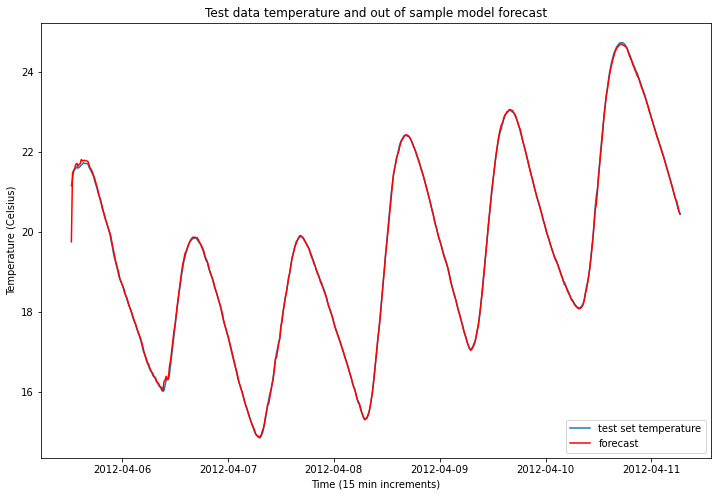

In [60]:
# Plot out of sample forecast
plt.figure(figsize = (12, 8))
plt.plot(y_test, label = 'test set temperature')
plt.plot(pred_by_time, color = 'red', label = 'forecast')

plt.legend(loc = 4)
plt.title('Test data temperature and out of sample model forecast')
plt.xlabel('Time (15 min increments)')
plt.ylabel('Temperature (Celsius)')
plt.show()

In [92]:
# Calculate out of sample error
rmse_reg = mean_squared_error(y_test, pred_by_time, squared = False)
r2_reg = r2_score(y_test, pred_by_time)

rmses.append(rmse_reg)
r2s.append(r2_reg)

rmse_reg, r2_reg

(0.07209785192855317, 0.9991370303793403)

In [98]:
reg.coef_

array([-3.26102699e-02,  2.87963935e-02, -1.53058232e-02,  2.25356162e-02,
       -5.21677291e-02,  8.03373061e-02,  2.51672185e-03, -2.92698162e-03,
       -1.49806170e-02,  4.97852594e-02,  6.06950496e-02,  9.18839937e-04,
        2.68903115e-04, -2.68903115e-04,  7.78379412e-03, -7.40329262e-03,
       -1.17141465e-03,  9.98871175e-01])

In [103]:
column_coefficients = list(zip(test.columns, reg.coef_))

In [105]:
sorted(column_coefficients, key = lambda x: -x[1])

[('indoor_temperature_room', 0.998871174657823),
 ('lighting_room', 0.08033730605232452),
 ('sun_irradiance', 0.06069504960535988),
 ('sun_light_in_south_facade', 0.049785259362131636),
 ('co2_room', 0.02879639353411214),
 ('relative_humidity_room', 0.02253561623898681),
 ('sun_dusk_full', 0.00778379411778443),
 ('wind', 0.002516721851878711),
 ('outdoor_relative_humidity', 0.0009188399370017112),
 ('rain_none', 0.0002689031145072275),
 ('rain_rain', -0.000268903114507172),
 ('sun_dusk_partial', -0.001171414652851912),
 ('sun_light_in_west_facade', -0.002926981622790094),
 ('sun_dusk_none', -0.007403292624309924),
 ('sun_light_in_east_facade', -0.01498061702125719),
 ('relative_humidity_dining_room', -0.015305823234494363),
 ('co2_dining_room', -0.032610269940679955),
 ('lighting_dining_room', -0.052167729051272704)]

### Section 4 Error Comparison and Concluding Remarks

In [94]:
# Create dataframe containing all three model error metrics
error_metrics = {'Root Mean Squared Error': rmses, 
                 'R Squared': r2s}
scoring_df = pd.DataFrame(error_metrics, index = ['manual_SARIMAX', 'hourly_manual_SARIMAX', 'hourly_auto_SARIMAX',
                                                  'untuned_rf', 'tuned_rf', 'linear_regression'])

In [95]:
scoring_df.sort_values(by = 'Root Mean Squared Error')

,Root Mean Squared Error,R Squared
linear_regression,0.072098,0.999137
tuned_rf,0.085201,0.998795
untuned_rf,0.086194,0.998767
manual_SARIMAX,2.407754,0.037557
hourly_manual_SARIMAX,2.647076,-0.167552
hourly_auto_SARIMAX,2.756455,-0.266033


As it turns out, a simple linear regression model best, despite our meticulous order inspection for the SARIMAX models. We introduced an element of time into the non SARIMAX models by adding the feature of the room temperatures lagged by one period. And its not surprise that by far the most important feature for the random forest regressors and highest coefficient for the regression model was this lagged temperature column. As we found from our EDA, our data set as a high degree of autocorrelation. This simple linear regression model took advantage of that fact by engineering the feature of temperature one period ago. With a high degree of accuracy it was able to forecast future temperature from the past. Our expectation going into this project was that a SARIMAX model would score the best when compared to atemporal models. It may have gone that way if not for a significant roadblock which bears discussing.

Our SARIMAX model was order (p = 0, d = 1, q = 0) and (P = 0, D = 1, Q = 1, S = 97). This means we took the first difference, the seasonal difference with a cycle of 97(!!), and found that the acf/pacf plots showed a seasonal moving average order of 1. Determing order by simple inspection may work often, but many data sets can be messy or tricky and difficult to judge the best order. This led us to our main problem: SARIMAX models may not do too well with seasonal data with large seasonal orders (https://github.com/statsmodels/statsmodels/issues/5727). Because SARIMAX models are so slow to train on seasonal time series' with high seasonal orders, we tried again with a downsampled dataset from 15 minute periods to hour periods. This scored better than the original data set. We then tried to optimize model parameters with auto_arima, again with the hourly dataset, but saw no increase in model performance.

The linear regression model ended up with a mse of ~0.072 degrees celsius. This just beyond of our goal of less than 0.05 C rmse. In the future, we would like to use a Long Short-Term Memory (LTSM) recurrent neural network with Keras. 